<a href="https://colab.research.google.com/github/Mochismo/LearnPython/blob/main/29_CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparing the dataset 

In [154]:
# Import
import numpy as np
import matplotlib.pyplot as plt
# Evaluation Index
from sklearn.metrics import accuracy_score

In [155]:
# Download mnist dataset 
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()

In [156]:
# Check the data
print(X.shape)
print(X_test.shape)
print(X[0].dtype)

(60000, 28, 28)
(10000, 28, 28)
uint8


In [157]:
# Type conversion, normalization
X = X.astype(np.float)
X_test = X_test.astype(np.float)
X /= 255
X_test /= 255
print(X.max())
print(X.min())

1.0
0.0


In [158]:
# One-hot encoding of correct label value
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y.shape)
print(y_one_hot.shape)
print(y_one_hot.dtype)

(60000,)
(60000, 10)
float64


In [159]:
# Split into training data and validation data
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y_one_hot, test_size = 0.2)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(48000, 28, 28)
(12000, 28, 28)
(48000, 10)
(12000, 10)


Fully connected layers

In [160]:
class FC:
  def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
    self.n_nodes1 = n_nodes1
    self.n_nodes2 = n_nodes2
    self.initializer = initializer
    self.optimizer = optimizer
    self.activation = activation
   
    # Initialize.
    # Use the initializer method to initialize self.W and self.B
    self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
    self.B = self.initializer.B(self.n_nodes2)

    
  def forward(self, X):
      self.X = X
      self.A = np.dot(self.X, self.W) + self.B
      return self.activation.forward(self.A) 

  def backward(self, dZ):
      dA = self.activation.backward(dZ)
      self.dB = np.mean(dA, axis=0)
      self.dW = np.dot(self.X.T, dA)/len(self.X)
      dZ = np.dot(dA, self.W.T)

      # update 
      self = self.optimizer.update(self)
      return dZ

Initialization

In [161]:
class SimpleInitializerConv2d:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma
    def W(self, F, C,FH, FW):
        """
        Weight initialization
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        W :
        """
        return self.sigma* np.random.randn(F, C,FH, FW)
        
    def B(self,F):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        B :
        """
        return np.zeros(F)      

In [162]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        W :
        """
        return self.sigma* np.random.randn(n_nodes1, n_nodes2)
        
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)

In [163]:
class HeInitializer:

  def __init__(self):
    pass

  def W(self, n_nodes1, n_nodes2):
    
    return np.random.randn(n_nodes1, n_nodes2)*np.sqrt(2 / n_nodes1)   

  def B(self, n_nodes2):
    
    return np.zeros(n_nodes2)    

Optimization

In [164]:
class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, layer):
      layer.W -= self.lr* layer.dW
      layer.B -= self.lr* layer.dB
      
      return layer
    """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
    """

In [165]:
class AdaGrad:

  def __init__(self, lr):
    self.lr = lr
    self.hW = 0
    self.hB = 0

  def update(self, layer):
    self.hW += layer.dW * layer.dW
    self.hB = layer.dB * layer.dB

    
    layer.W -=self.lr * layer.dW / (np.sqrt(self.hW) + 1e-7)
    layer.B -=self.lr * layer.dB / (np.sqrt(self.hB) + 1e-7)
    return layer  

Activation Function 

In [166]:
class ReLU:
  
  def __init__(self):
    pass

  def forward(self, A): 
    self.A = A
    return np.maximum(self.A, 0)
      
  def backward(self, dZ):
    return np.where(self.A > 0, dZ, 0)

In [167]:
class softmax():

  def __init__(self):
    pass

  def forward(self, A):
    return np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)), axis=1, keepdims=True)
      
  def backward(self, dZ):
    
    return dZ


MiniBatch

In [168]:
class GetMiniBatch:

  def __init__(self, X, y, batch_size = 20, seed=None):
    self.batch_size = batch_size
    np.random.seed(seed)
    shuffle_index = np.random.permutation(np.arange(X.shape[0]))
    self._X = X[shuffle_index]
    self._y = y[shuffle_index]
    self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

  def __len__(self):
    return self._stop

  def __getitem__(self, item): 
    p0 = item*self.batch_size
    p1 = item*self.batch_size + self.batch_size
    return self._X[p0:p1], self._y[p0:p1]

  def __iter__(self): 
    self._counter = 0
    return self 

  def __next__(self):
    if self._counter >= self._stop:
      raise StopIteration()
    p0 = self._counter*self.batch_size
    p1 = self._counter*self.batch_size + self.batch_size 
    self._counter += 1
    return self._X[p0:p1], self._y[p0:p1] 

## 【Problem 1】Creating a 2-D convolutional layer

In [169]:
class SimpleConv2d():
    
    def __init__(self, F, C, FH, FW, P, S, initializer=None, optimizer=None, activation=None):

      self.P = P
      self.S = S
      self.initializer = initializer
      self.optimizer = optimizer
      self.activation = activation

      # Initialize.
      # Use initializer method to initialize self.W and self.B
      self.W =self.initializer.W(F, C, FH, FW)
      self.B = self.initializer.B(F)

    def output_shape2d(self, H, W, PH, PW, FH, FW, SH, SW):

      OH = (H + 2*PH - FH)/SH +1
      OW = (W + 2*PW - FW)/SW +1
      return int(OH), int(OW)

    def forward(self, X):
      self.X = X
      N, C, H, W = self.X.shape
      F, C, FH, FW = self.W.shape

      OH, OW = self.output_shape2d(H, W, self.P, self.P, FH, FW, self.S, self.S)

      self.params = N,C,H,W,F,FH,FW,OH,OW

      A = np.zeros((N,F,OH,OW))  
      self.X_pad = np.pad(self.X,((0,0),(0,0),(self.P, self.P), (self.P, self.P)))

      #Batch
      for n in range(N):
        #output channels
        for ch in range(F):
          #vertical slide
          for row in range(0,H,self.S):
            # horizontal slide
            for col in range(0,W,self.S):
              A[n,ch,row,col] = np.sum(self.X_pad[n,:, row:row + FH, col:col+FW]*self.W[ch,:,:,:]) +self.B[ch]
      return self.activation.forward(A)

    def backward(self, dZ):
      dA = self.activation.backward(dZ)
      N, C, H, W, F, FH, FW, OH, OW = self.params
      
      dZ = np.zeros(self.X_pad.shape)
      self.dW = np.zeros(self.W.shape) 
      self.dB = np.zeros(self.B.shape)

      #dZ
      #Batch
      for n in range(N):
        # Output channels
        for ch in range(F):
          # Vertical slide
          for row in range(0,H,self.S):
            # Horizontal Slide
            for col in range(0,W,self.S):
              dZ[n,:,row:row+FH, col:col+FW] += dA[n,ch,row,col]*self.W[ch,:,:,:]
      dl_rows = range(self.P),range(H+self.P,H+2*self.P,1)
      dl_cols = range(self.P),range(W+self.P,W+2*self.P,1)

      dZ = np.delete(dZ,dl_rows,axis=2)
      dZ = np.delete(dZ,dl_cols,axis=3)

      #dW
      #Batch
      for n in range(N):
        # Output channels
        for ch in range(F):
          # Vertical slide
          for row in range(OH):
            # Horizontal Slide
            for col in range(OW):
              self.dW[ch,:,:,:] += dA[n,ch,row,col]*self.X_pad[n,:,row:row+FH,col:col+FW]
      #dB
      #Output channels
      for ch in range(F):
        self.dB[ch] = np.sum(dA[:,ch,:,:])
      #update
      self = self.optimizer.update(self)  
      return dZ      

Problem 2 & 3 - Experiments with 2D convolutional layers on small arrays and output size after 2-dimensional convolution

In [170]:
def output_shape2d(IH=5,IW=5,PH=0,PW=0,FH=3,FW=3,SH=1,SW=1):
  OH = (IH + 2*PH -FH)/SH +1
  OW = (IW + 2*PW -FW)/SW +1
  return int(OH), int(OW)

In [171]:
print(output_shape2d(IH=6,IW=6,PH=0,PW=0,FH=3,FW=3,SH=1,SW=1))

(4, 4)


Experiment with 2D convolution

In [172]:
N,C,H,W = (5,1,28,28)
F,C,FH,FW = (4,1,3,3)

S = 1 #FIXED FOR NOW
P = 1

OH,OW = output_shape2d(H,W,P,P,FH,FW,S,S)

A = np.zeros([N,F,OH,OW])
X_sample = X[0:N].reshape(N,C,H,W)
X_pad = np.pad(X_sample,((0,0),(0,0),(P,P),(P,P)))
w = np.ones([F,C,FH,FW])
B = np.ones(F)

#Forward
#Batch
for n in range(N):
  # Output channels
  for ch in range(F):
    # Vertical slide
    for row in range(0,H,S):
      # Horizontal Slide
      for col in range(0,W,S):
        A[n,ch,row,col] = np.sum(X_pad[n,:,row:row+FH,col:col+FW]*w[ch,:,:,:]) +B[ch]
print('A.shape:', A.shape)

A.shape: (5, 4, 28, 28)


In [173]:
#backward
dA = np.ones(A.shape)
      
dZ = np.zeros(X_pad.shape)
dW = np.zeros(w.shape) 
dB = np.zeros(B.shape)

#dZ
#Batch
for n in range(N):
  # Output channels
  for ch in range(F):
    # Vertical slide
    for row in range(0,H,S):
      # Horizontal Slide
      for col in range(0,W,S):
        dZ[n,:,row:row+FH, col:col+FW] += dA[n,ch,row,col]*w[ch,:,:,:]
dl_rows = range(P),range(H+P,H+2*P,1)
dl_cols = range(P),range(W+P,W+2*P,1)

dZ = np.delete(dZ,dl_rows,axis=2)
dZ = np.delete(dZ,dl_cols,axis=3)

#dW
#Batch
for n in range(N):
  # Output channels
  for ch in range(F):
    # Vertical slide
    for row in range(OH):
      # Horizontal Slide
      for col in range(OW):
        dW[ch,:,:,:] += dA[n,ch,row,col]*X_pad[n,:,row:row+FH,col:col+FW]
#dB
#Output channels
for ch in range(F):
  dB[ch] = np.sum(dA[:,ch,:,:])

print('dZ.shape:',dZ.shape)     
print('dW.shape:',dW.shape)
print('dB.shape:',dB.shape)

dZ.shape: (5, 1, 28, 28)
dW.shape: (4, 1, 3, 3)
dB.shape: (4,)


Problem 4 - Creating a maximum pooling layer

In [174]:
class MaxPool2D():
  def __init__(self, P):
    self.P = P
    self.PA = None
    self.Pindex = None
  def forward(self,A):
    N,F,OH,OW = A.shape
    PS = self.P
    PH,PW = int(OH/PS),int(OW/PS)

    self.params = N,F,OH,OW,PS,PH,PW

    #pooling filter
    self.PA = np.zeros([N,F,PH,PW])
    self.Pindex = np.zeros([N,F,PH,PW])

    for n in range(N):
      # Output channels
      for ch in range(F):
        # Vertical slide
        for row in range(PH):
          # Horizontal Slide
          for col in range(PW):
            self.PA[n,ch,row,col] = np.max(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
            self.Pindex[n,ch,row,col] = np.argmax(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
    return self.PA

  def backward(self, dA):
    N, F, OH, OW, PS, PH, PW = self.params
    dP = np.zeros([N,F,OH,OW])
    
    for n in range(N):
      # Output channels
      for ch in range(F):
        # Vertical slide
        for row in range(PH):
          # Horizontal Slide
          for col in range(PW):
            idx = self.Pindex[n,ch,row,col]
            tmp = np.zeros((PS*PS))
            for i in range((PS*PS)):
              if i == idx:
                tmp[i] = dA[n,ch,row,col]
              else:
                tmp[i] = 0
            dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
    return dP

In [175]:
X = np.random.randint(0,9,36).reshape(1,1,6,6)
print(X)

[[[[6 7 5 6 1 2]
   [6 1 1 6 2 6]
   [0 6 3 0 6 0]
   [5 0 5 3 2 2]
   [1 5 2 4 3 4]
   [0 6 5 8 3 2]]]]


In [176]:
Pooling = MaxPool2D(P=2)
A = Pooling.forward(X)
print(A.shape)
print(A)

(1, 1, 3, 3)
[[[[7. 6. 6.]
   [6. 5. 6.]
   [6. 8. 4.]]]]


In [177]:
Pooling.Pindex

array([[[[1., 1., 3.],
         [1., 2., 0.],
         [3., 3., 1.]]]])

In [178]:
dA = np.random.randint(0,9,9).reshape(A.shape)
print(dA)

[[[[2 8 4]
   [8 3 4]
   [8 5 3]]]]


In [179]:
dZ = Pooling.backward(dA)

print(dZ)

[[[[0. 2. 0. 8. 0. 0.]
   [0. 0. 0. 0. 0. 4.]
   [0. 8. 0. 0. 4. 0.]
   [0. 0. 3. 0. 0. 0.]
   [0. 0. 0. 0. 0. 3.]
   [0. 8. 0. 5. 0. 0.]]]]


Problem 5 - (Advanced) Creating Average Pooling

In [180]:
class AveragePool2D():
  def __init__(self, P):
    self.P = P
    self.PA = None
    self.Pindex = None
  def forward(self,A):
    N,F,OH,OW = A.shape
    PS = self.P
    PH,PW = int(OH/PS),int(OW/PS)

    self.params = N,F,OH,OW,PS,PH,PW

    #pooling filter
    self.PA = np.zeros([N,F,PH,PW])

    for n in range(N):
      # Output channels
      for ch in range(F):
        # Vertical slide
        for row in range(PH):
          # Horizontal Slide
          for col in range(PW):
            self.PA[n,ch,row,col] = np.mean(A[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS])
    return self.PA

  def backward(self, dA):
    N, F, OH, OW, PS, PH, PW = self.params
    dP = np.zeros([N,F,OH,OW])
    
    for n in range(N):
      # Output channels
      for ch in range(F):
        # Vertical slide
        for row in range(PH):
          # Horizontal Slide
          for col in range(PW):
            tmp = np.zeros((PS*PS))
            for i in range((PS*PS)):
                tmp[i] = dA[n,ch,row,col]/(PS*PS)
            dP[n,ch,row*PS:row*PS+PS,col*PS:col*PS+PS] = tmp.reshape(PS,PS)
    return dP

In [181]:
X = np.random.randint(0,9,36).reshape(1,1,6,6)
print(X)

[[[[2 1 4 5 3 8]
   [1 2 2 2 6 0]
   [0 8 2 8 6 7]
   [8 7 8 6 4 8]
   [4 6 7 1 2 7]
   [1 8 5 8 8 7]]]]


In [182]:
Pooling = AveragePool2D(P=2)
A = Pooling.forward(X)
print(A.shape)
print(A)

(1, 1, 3, 3)
[[[[1.5  3.25 4.25]
   [5.75 6.   6.25]
   [4.75 5.25 6.  ]]]]


In [183]:
dA = np.random.randint(0,9,9).reshape(A.shape)
print(dA)

[[[[4 4 3]
   [4 1 6]
   [5 6 2]]]]


In [184]:
dZ = Pooling.backward(dA)

print(dZ)

[[[[1.   1.   1.   1.   0.75 0.75]
   [1.   1.   1.   1.   0.75 0.75]
   [1.   1.   0.25 0.25 1.5  1.5 ]
   [1.   1.   0.25 0.25 1.5  1.5 ]
   [1.25 1.25 1.5  1.5  0.5  0.5 ]
   [1.25 1.25 1.5  1.5  0.5  0.5 ]]]]



Problem 6 - Flatten for smoothing

In [185]:
class Flatten:
  def __ini__(self,):
    pass
  def forward(self,X):
    self.shape = X.shape
    return X.reshape(len(X),-1)

  def backward(self,X):
    return X.reshape(self.shape)  

In [186]:
TEST = np.zeros([20,2,5,5])
flt = Flatten()
flat_forward = flt.forward(TEST)
print('Forward_shape:', flat_forward.shape)
print('Backward_shape:', flt.backward(flat_forward).shape)

Forward_shape: (20, 50)
Backward_shape: (20, 2, 5, 5)


Problem 7 - Training and Estimation 

In [187]:
#Scratch CNN
class Scratch2dCNNClassifier():
    def __init__(self, NN, CNN, n_epoch=5, n_batch=1, verbose=False):
      #parameters
      self.n_epoch = n_epoch
      self.n_batch = n_batch
      self.verbose = verbose
      self.log_loss = np.zeros(self.n_epoch)
      self.log_acc = np.zeros(self.n_epoch)
      self.NN = NN
      self.CNN = CNN

    def loss_function(self,y,yt):
      delta = 1e-7
      return -np.mean(yt*np.log(y+delta))

    def accuracy(self,Z,Y):
      return accuracy_score(Y,Z)

    def fit(self, X, y, X_val=False, y_val=False):
      for epoch in range(self.n_epoch):
        #Mini-Batch Processing
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)

        self.loss = 0
        for mini_X_train, mini_y_train in get_mini_batch:
          #Forward Propagation
          forward_data = mini_X_train[:,np.newaxis,:,:]

          #Conv
          for layer in range(len(self.CNN)):
            forward_data = self.CNN[layer].forward(forward_data)

          #Flatten
          flt = Flatten()
          forward_data = flt.forward(forward_data)

          #NN
          for layer in range(len(self.NN)):
            forward_data = self.NN[layer].forward(forward_data)

          #Predicted Value
          Z = forward_data

          #Back Propagation
          backward_data = (Z - mini_y_train)/self.n_batch
          for layer in range(len(self.NN)-1,-1,-1):
            backward_data = self.NN[layer].backward(backward_data)

          backward_data = flt.backward(backward_data)

          for layer in range(len(self.CNN)-1,-1,-1):
            backward_data = self.CNN[layer].backward(backward_data)

          #Loss function
          self.loss += self.loss_function(Z,mini_y_train)
      
        self.log_loss[epoch] = self.loss/len(get_mini_batch)
        self.log_acc[epoch] = self.accuracy(self.predict(X), np.argmax(y, axis=1))
    def predict(self, X):
      pred_data = X[:,np.newaxis,:,:]

      #Conv
      for layer in range(len(self.CNN)):
        pred_data = self.CNN[layer].forward(pred_data)

        flt = Flatten()
        pred_data = flt.forward(pred_data)

        #NN
        for layer in range(len(self.NN)):
          pred_data = self.NN[layer].forward(pred_data)

        return np.argmax(pred_data, axis=1)

In [188]:
#All bounding layers
NN = {0:FC(7840, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
      1:FC(400, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
      2:FC(200, 10,SimpleInitializer(0.01),AdaGrad(0.01), softmax()),}

In [189]:
#Convolutional Layer
CNN = {0:SimpleConv2d(F=10, C=1, FH=3, FW=3, P=1,S=1,
                      initializer=SimpleInitializerConv2d(),
                      optimizer=SGD(),
                      activation=ReLU())}

In [190]:
# Learning
cnn1 = Scratch2dCNNClassifier(NN=NN,CNN=CNN,n_epoch=10,n_batch=200,verbose=False)

cnn1.fit(X_train[0:1000], y_train[0:1000])

In [193]:
#Estimate
y_pred = cnn1.predict(X_valid[0:100])

#Positive solution rate
accuracy = accuracy_score(np.argmax(y_valid[0:100],axis=1), y_pred)
print('accuracy:{:.3f}'.format(accuracy))

accuracy:0.790


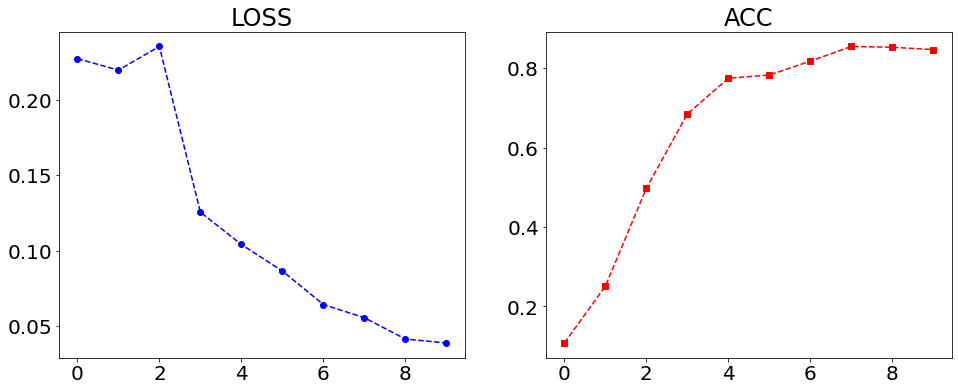

In [194]:
#Visualise the loss function for each epoch
plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(cnn1.log_loss, 'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(cnn1.log_acc, 'rs--');

Problem 8 (Advanced Assignment)- LeNet

In [ ]:
#LeNet structure
#Convolutional layers
LeNetCNN = {0:SimpleConv2d(F=6, C=1, FH=5, FW=5, P=2,S=1,
                      initializer=SimpleInitializerConv2d(),
                      optimizer=SGD(),
                      activation=ReLU()),
       1:MaxPool2D(P=2),
       2:SimpleConv2d(F=6, C=1, FH=5, FW=5, P=2,S=1,
                      initializer=SimpleInitializerConv2d(),
                      optimizer=SGD(),
                      activation=ReLU()),
       3:MaxPool2D(P=2)}

#Fully connected layers
LeNetNN = {0:FC(7840, 400,HeInitializer(),AdaGrad(0.01), ReLU()),
      1:FC(400, 200,HeInitializer(),AdaGrad(0.01), ReLU()),
      2:FC(200, 10,SimpleInitializer(0.01),AdaGrad(0.01), softmax()),}

# Learning
LeNet = Scratch2dCNNClassifier(NN=LeNetNN,CNN=LeNetCNN,n_epoch=10,n_batch=20,verbose=False)

cnn1.fit(X_train[0:1000], y_train[0:1000])

In [ ]:
y_pred_LeNet = cnn1.predict(X_valid[0:100])

#Positive solution rate
accuracy = accuracy_score(np.argmax(y_valid[0:100],axis=1), y_pred_LeNet)
print('accuracy:{:.3f}'.format(accuracy))

In [ ]:
#Visualise the loss function for each epoch
plt.rcParams["font.size"] = 20
fig = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(LeNet.log_loss, 'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(LeNet.log_acc, 'rs--');

Problem 9- (Advanced) List of famous CNN structures:


* AlexNet(2012
* ZFNet(2013)
* GoogleNet(2014)
* VGGNet(2014)
* ResNet(2015)
* SENet(2017)



Problem 10 - Calculating output size and number of parameters
1. 
* Input size : 144 x 144, 3 channels
* Filter size: 3 x 3, 6 channels
* Stride : 1
* Padding: None
* Output size: 6x142x142, Number of parameters: 10416(weight=162, bias=6)
2.
* Input size : 60x60, 24 channels
* Filter size: 3 x 3, 48 channels
* Stride : 1
* Padding: None
* Output size: 48x58x58, Number of parameters: 10416(weight=10368, bias=48)
3.
* Input size : 20x20, 10 channels
* Filter size: 3 x 3, 20 channels
* Stride: 2
* Padding: None
* Output size: 20x9x9, Number of parameters: 1820(weight=1800, bias=20)



Problem 11- Survey of Filter Size
1. Why are 3x3 filters commonly used instead of larger ones such as 7x7?
   * This is because the parameters will be huge. The purpose of convolution is to extract features (including positional relationships) between input parameters. Increasing the filter size is going against this reason.
2. Whatis the effect of a 1x1 filter with no height or width direction
   * The filter doesn't do anything to the image and it remains the same even after the process. 